In [15]:
# importing libraries
import pandas as pd
from nltk.corpus import stopwords
import joblib
from sklearn.model_selection import train_test_split
import string
from sklearn.metrics import classification_report
import re
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")

In [19]:
#Initialise data path
data_path = "/home/jovyan/input/data/"

#Read train data
data = pd.read_parquet(data_path + "train.parquet")

In [1]:
# data = pd.read_csv("final_processed_csv.csv")

## Feature creation

In [20]:
# 0.9523
# embeddinng + lgbm
# Note: This below feature helped to increase score by 0.0020-> 
# from 0.9523 to 0.9538-> 0.0030

def get_method_name(code:str)->str:
    """Extracting method name from method name as a feature"""
    
    return code.split(":")[0]

In [21]:
data['method_feature'] = data['code'].apply(get_method_name)

In [22]:
STOP_WORDS = stopwords.words("english")
custom_stowords_list = ['def','self','returns','return',
                        'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
                       'zzzzzzzzzz','zzzzzzzz','zzzzzzz','zzzzz',
                       'aaaabnzacyceaaaadaqabaaabaqddurxdpyhoquyodutxjduzqmjyjqjszt',
       'aaaabnzacyceaaaadaqabaaabaqdcgxehzf', 'aaaabnzacyceaaa',
       'aaaabnzacyce', 'aaaabnzacyc', 'aaaabnzacy',
       'aaaabnzackcmaaacbakdpkarimlm', 'aaaabbbccdaabbb', 'aaaabbbcca',
       'aaaabaaacaaadaaaeaaafaaagaaahaaaiaaajaaakaaalaaamaaanaaaoaaapaaaqaaaraaasaaataaa',
       'aaaaargh', 'aaaaabaaa', 'aaaaabaa',
       'aaaaaaeceeeeiiiidnoooooouuuuysaaaaaaaceeeeiiii', 'aaaaaabaedaa',
       'aaaaaaaarge', 'aaaaaaaalaaaaaaadwpwaaaaaaaaaa',
       'aaaaaaaalaaaaaaadwpqzmzmzmdk', 'aaaaaaaadjuqwsqicqdwlclimq',
       'aaaaaaaaaaagaagaaagaaa', 'aaaaaaaaaaaahaaaaaaaaa',
       'aaaaaaaaaaaaaaaaaadwpwaaaaaaapc',
       'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
       'aaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaa',
       'aaaaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaa',
       'aaaaaaaaa', 'aaaaaaaa', 'aaaaaaa', 'aaaaaa', 'aaaaa', 'aaaa',
       'aaa', 'aa']

In [23]:
STOP_WORDS.extend(custom_stowords_list)

In [24]:

def preprocess(x):
    x = str(x).lower()
    y = []
    for zz in x.split():
        if zz.lower() not in STOP_WORDS or zz.lower() not in custom_stowords_list:
            y.append(zz)
    x = " ".join(y)        
    x = re.sub(r"([0-9]+)","", x)

    return x

def clean_data(lines):
    
    cleaned = []
    for line in lines.split("\n"):
        clean = re.sub(r"""
               [,.;@#?!&$()='\\_`:>"%/{}*]+  # Accept one or more copies of punctuation
               \ *           # plus zero or more copies of a space,
               """,
               " ",          # and replace it with a single space
               line, flags=re.VERBOSE)
        # below line to remove chinese and non-english character but 
        #using this f1-score is getting reduced...
        # clean = re.sub(r"[^a-zA-Z0-9 ]+","",clean)
        
        #Manually handle cases not accepted by sub
        clean = clean.replace("[", "")
        clean = clean.replace("+", "")
        clean = clean.replace("]", "")
        clean = clean.replace("-", "")
        
        # tokenize on white space
        line = clean.split()
        
        # convert to lower case
        line = [word.lower() for word in line]
        # store as string
        cleaned.append(' '.join(line))
    # remove empty strings
    return " ".join(cleaned)

In [25]:
def pre_processing_pipeline(df):

    def convert_html_text(text):
        """ function convert http link to text"""

        if 'https://' in text:
            for pattern in string.punctuation:
                text = text.replace(pattern," ")

            return text
        else:
            return text
    
    
    def extract_features(df):
        # preprocessing each question
        print(f"[Info] Running cleaning pipeline!")
        
        df["code"] = df["code"].fillna("").apply(clean_data)
        df["docstring"] = df["docstring"].fillna("").apply(clean_data)
        df["method_feature"] = df["method_feature"].fillna("").apply(clean_data)
        
        print(f"[Info] Cleaning done!")
        
        return df
    
    ##conveting hyperlinks to string format
    df['docstring'] = df['docstring'].apply(
        convert_html_text
    )
    
    df = extract_features(df)
    
    print(f"[Info] Running stopwords removal pipeline!")
    
    df['code'] = df['code'].apply(preprocess)
    df['docstring'] = df['docstring'].apply(preprocess)
    df["method_feature"] = df["method_feature"].apply(preprocess)
    
    print(f"[Info] Stopwords removal complete!")
    
    return df
    

In [26]:
# running pre-porcessing pipeline
%time

data = pre_processing_pipeline(data)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.39 µs
[Info] Running cleaning pipeline!
[Info] Cleaning done!
[Info] Running stopwords removal pipeline!
[Info] Stopwords removal complete!


## Creating similarity level feature between code & docsting

In [27]:
from collections import Counter
import math

# 0.9538 -> 0.9628

def counter_cosine_similarity(c1,c2):
    
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k,0)*c2.get(k,0) for k in terms)
    magA = math.sqrt(sum(c1.get(k,0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k,0)**2 for k in terms))
    
    try:
        return dotprod/(magA*magB)
    except:
        return 0
        

In [28]:
# checking cosine similarity 
testId = 2

print(counter_cosine_similarity(Counter(data.code.iloc[testId].split(" ")),
                                Counter(data.docstring.iloc[testId].split(" "))))

0.0


In [31]:
%time

data['sim_score'] = data.apply(lambda x: 
                               counter_cosine_similarity(Counter(x['code'].split(" ")),
                                                        Counter(x['docstring'].split(" "))),
                               axis=1
                              )

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [32]:
!pip install -q lightgbm
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

In [33]:
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    #plt.figure(figsize = (10,7))
    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})# font size
    plt.show()
    
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [6]:
# creating embedding 
!pip install -q sentence-transformers

In [7]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "True"

In [8]:
from sentence_transformers import SentenceTransformer,util
# model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model_name = "all-MiniLM-L6-v2" # 68 f1
model = SentenceTransformer(model_name)

2022-12-01 06:57:47.722581: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# code_embeds = data.code.values
# code_embedding_ = model.encode(code_embeds,show_progress_bar=True)

In [10]:
# code_feature = data.method_feature.values
# code_embedding_feature = model.encode(code_feature,show_progress_bar=True)

In [11]:
# doc_embeds = data.docstring.values
# doc_embedding_ = model.encode(doc_embeds,show_progress_bar=True)

In [34]:
import numpy as np

code_embeds1 = np.load('code_embedding.npy')
code_feature1 = np.load('code_feature_embedding_old.npy')
doc_embeds1 = np.load('docstring_embedding.npy')

In [35]:
train_c = np.concatenate([code_feature1,
                          doc_embeds1,
                          code_embeds1],axis=1)

In [36]:
# data.head(2)

In [37]:
features_array = data[['sim_score']].to_numpy()

In [38]:
train_c_with_features = np.concatenate(
    [train_c,features_array],
    axis=1)

In [39]:
# train_c_with_features.shape

In [40]:
#Split data into train and val data
train, val,ytrain,yval = train_test_split(train_c_with_features,
                              data.y_true, 
                              test_size = 0.3,
                              stratify=data.y_true,
                              random_state = 123,
                             shuffle=True)

In [41]:
params = {
    'learning_rate': 0.06,
    'lambda_l1': 7.71800699380605e-05,
    'lambda_l2': 4.17890272377219e-06,
    'bagging_fraction': 0.7000000000000001,
    'feature_fraction': 0.4,
    'bagging_freq': 5,
    'max_depth': 5,
    'num_leaves': 1007,
    'min_data_in_leaf': 45,
    'n_estimators': 2000,
    'colsample_bytree': 0.5,
    'metric': 'f1_score'
}

full_clf = LGBMClassifier(**params)
full_clf.fit(train_c_with_features,data.y_true)

[LightGBM] [Warning] lambda_l1 is set=7.71800699380605e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.71800699380605e-05
[LightGBM] [Warning] bagging_fraction is set=0.7000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=4.17890272377219e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.17890272377219e-06
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMClassifier(bagging_fraction=0.7000000000000001, bagging_freq=5,
               colsample_bytree=0.5, feature_fraction=0.4,
               lambda_l1=7.71800699380605e-05, lambda_l2=4.17890272377219e-06,
               learning_rate=0.06, max_depth=5, metric='f1_score',
               min_data_in_leaf=45, n_estimators=2000, num_leaves=1007)

In [29]:
# from sklearn.model_selection import KFold


# def f1_metric(ytrue,preds):
#     ''' Return the F1 Score value for the preds and true values, ytrue '''
#     return 'f1_score', f1_score((preds>=0.5).astype('int'), ytrue, average='macro'), True

# params = {
#     'learning_rate': 0.03,
#     'lambda_l1': 7.71800699380605e-05,
#     'lambda_l2': 4.17890272377219e-06,
#     'bagging_fraction': 0.7000000000000001,
#     'feature_fraction': 0.4,
#     'bagging_freq': 5,
#     'max_depth': 5,
#     'num_leaves': 1007,
#     'min_data_in_leaf': 45,
#     'n_estimators': 3000,
#     'colsample_bytree': 0.5,
#     'metric': 'f1_score'
# }

# full_clf = LGBMClassifier(**params)

# # Fit or train the xgboost model
# full_clf.fit(train.astype(np.float32), 
#              ytrain, 
#              eval_set=[(train.astype(np.float32), ytrain), 
#                        (val.astype(np.float32), yval)],
#              verbose=400, 
#              eval_metric=f1_metric)

# #Show the results
# print("train score:", full_clf.score(
#     train.astype(np.float32), ytrain)
#      )
# print("test score:", full_clf.score(
#     val.astype(np.float32), yval)
#      )

In [43]:
joblib.dump(full_clf,"lgbm_sentence_model_whole_data_with_sim_2000.pkl")

['lgbm_sentence_model_whole_data_with_sim_2000.pkl']

              precision    recall  f1-score   support

           0    0.98647   0.98364   0.98505     60940
           1    0.99455   0.99550   0.99503    182818

    accuracy                        0.99254    243758
   macro avg    0.99051   0.98957   0.99004    243758
weighted avg    0.99253   0.99254   0.99253    243758



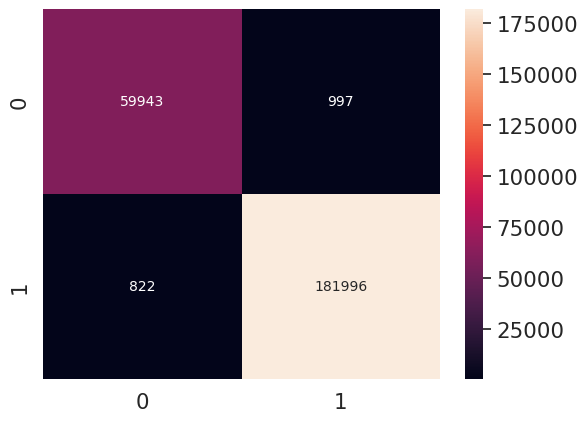

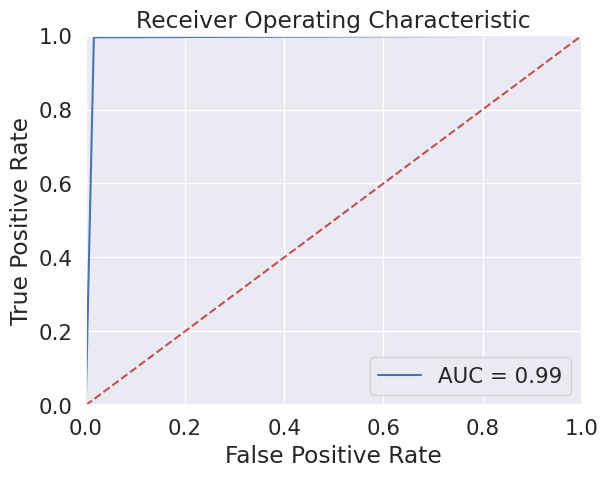

In [25]:
# Predicting the Test set results
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,roc_curve,auc
import seaborn as sn

y_pred = full_clf.predict(train.astype(np.float32))

print(classification_report(ytrain, y_pred,  digits=5))
plot_confussion_matrix(ytrain, y_pred)
plot_roc_curve(ytrain, y_pred)

              precision    recall  f1-score   support

           0    0.98639   0.98549   0.98594     26117
           1    0.99516   0.99547   0.99532     78351

    accuracy                        0.99297    104468
   macro avg    0.99078   0.99048   0.99063    104468
weighted avg    0.99297   0.99297   0.99297    104468



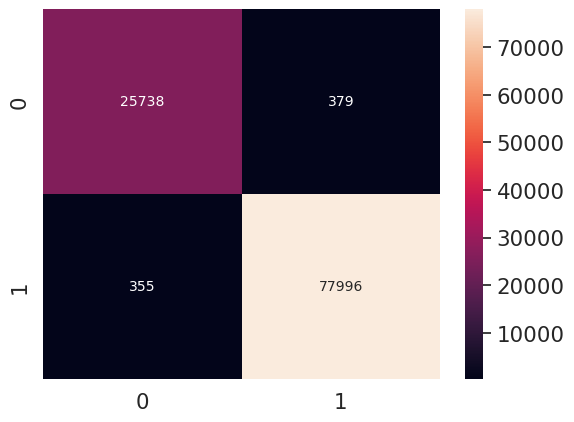

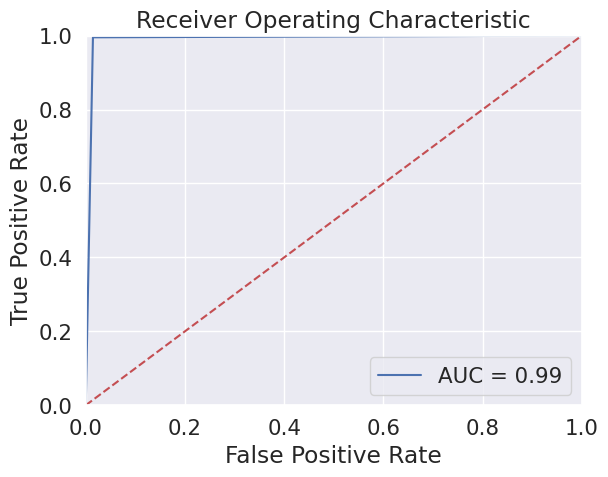

In [26]:
# Predicting the Test set results
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,roc_curve,auc
import seaborn as sn

y_pred = full_clf.predict(val.astype(np.float32))

print(classification_report(yval, y_pred,  digits=5))
plot_confussion_matrix(yval, y_pred)
plot_roc_curve(yval, y_pred)